<a href="https://colab.research.google.com/github/kishiyamat/la-kentei-yaminabe/blob/main/notebooks/talking_aid_minimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 意味を考慮して再現するには？

## 単語の関連度合い

### インストール

In [4]:
! pip install -U ginza ja_ginza

# Word2vecのダウンロードには8分程度かかるので気長に待つ。
import os
from gensim.models import KeyedVectors

# word2vec
filename = "20170201.tar.bz2"
url = f"http://www.cl.ecei.tohoku.ac.jp/~m-suzuki/jawiki_vector/data/{filename}"

# ファイルが存在しない場合のみダウンロードを実行
if not os.path.exists(filename):
    # 中断するとentity_vector/entity_vector.model.binが生成されず以下のエラーとなる。ランタイムを削除する。
    # FileNotFoundError: [Errno 2] No such file or directory: 'entity_vector/entity_vector.model.bin'
    os.system(f"wget {url}")
    os.system(f"tar -xvjf {filename}")

# モデルのロード含めて30秒程度かかる
model_dir = 'entity_vector/entity_vector.model.bin'
model = KeyedVectors.load_word2vec_format(
    model_dir, binary=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 MB 12.1 MB/s eta 0:00:00


### 類義語の取得

In [5]:
TOP_N = 30
word = '日比谷'

results = model.most_similar(word, topn=TOP_N)
for result in results:
    print(result)

('[日比谷]', 0.8020889163017273)
('代々木', 0.7554340362548828)
('池袋', 0.7515247464179993)
('市ヶ谷', 0.7447957396507263)
('赤坂', 0.7336158752441406)
('日本橋', 0.7313567399978638)
('吉祥寺', 0.7304186224937439)
('新宿', 0.7302600741386414)
('[有楽町]', 0.7218155860900879)
('丸の内', 0.7200046181678772)
('麹町', 0.719078779220581)
('目黒', 0.7163709998130798)
('高島屋', 0.7140048742294312)
('有楽町', 0.7135686278343201)
('サンモール', 0.7133216261863708)
('世田谷', 0.712195634841919)
('幕張', 0.7050204277038574)
('[青山_(東京都港区)]', 0.701943576335907)
('荻窪', 0.7004520297050476)
('代官山', 0.6979202032089233)
('高円寺', 0.6950085759162903)
('[蒲田]', 0.694953203201294)
('千代田', 0.6942139267921448)
('[赤坂_(東京都港区)]', 0.693513035774231)
('[池袋]', 0.6934029459953308)
('恵比寿', 0.6929343938827515)
('渋谷', 0.6923547983169556)
('梅田', 0.6909371018409729)
('銀座', 0.6885918378829956)
('四谷', 0.6877546310424805)


### ベクトルの計算

In [6]:
# うまくいく例
model.similar_by_vector(model["フランス"]-(model["日本"]-model["東京"]))

[('パリ', 0.7044169902801514),
 ('[パリ]', 0.6613379120826721),
 ('ミラノ', 0.6109405755996704),
 ('ベルリン', 0.6060323119163513),
 ('ロンドン', 0.5957039594650269),
 ('ウィーン', 0.5881831645965576),
 ('ブリュッセル', 0.5833532214164734),
 ('ミュンヘン', 0.5820050835609436),
 ('東京', 0.5713459849357605),
 ('ハンブルク', 0.5672899484634399)]

In [7]:
# うまくいかない例。なんだこれ。理想の状態なら日比谷のランドマークがでてくる。
model.similar_by_vector(model["日比谷"]-(model["渋谷"]-model["ハチ公"]))

[('鍾乳', 0.3092036545276642),
 ('[パーマストン子爵ヘンリー・ジョン・テンプル]', 0.3078872859477997),
 ('キャフェリー', 0.30557936429977417),
 ('[三色旗]', 0.303909033536911),
 ('複合構造', 0.3002869188785553),
 ('[カール・ヴィルヘルム・シェーレ]', 0.2991071939468384),
 ('[青銅]', 0.29861482977867126),
 ('[導火線]', 0.29715192317962646),
 ('[冶金]', 0.29567959904670715),
 ('フェイシング', 0.29326754808425903)]

## 音素列間の類似度

### 音素への変換

In [8]:
import spacy

# Ginzaモデルをロード(読みを取得する目的)
nlp = spacy.load('ja_ginza')

# ローマ字→カナへの変換
def word_to_romaji(text):
    doc = nlp(text)
    kana_list = []
    for sent in doc.sents:
        for token in sent:
            # 漢字→カナ
            kana_list.extend(token.morph.get("Reading"))
    # カナ→ローマ字
    return kana_to_romaji_conversion("".join(kana_list))

# 読み仮名からローマ字への変換辞書
# 「チャ」は ti_ya となってしまう程度のナイーブさ
kana_to_romaji = {
    'ア': 'a', 'イ': 'i', 'ウ': 'u', 'エ': 'e', 'オ': 'o',
    'カ': 'ka', 'キ': 'ki', 'ク': 'ku', 'ケ': 'ke', 'コ': 'ko',
    'ガ': 'ga', 'ギ': 'gi', 'グ': 'gu', 'ゲ': 'ge', 'ゴ': 'go',
    'サ': 'sa', 'シ': 'si', 'ス': 'su', 'セ': 'se', 'ソ': 'so',
    'ザ': 'za', 'ジ': 'zi', 'ズ': 'zu', 'ゼ': 'ze', 'ゾ': 'zo',
    'タ': 'ta', 'チ': 'ti', 'ツ': 'tu', 'テ': 'te', 'ト': 'to',
    'ダ': 'da', 'ヂ': 'di', 'ヅ': 'du', 'デ': 'de', 'ド': 'do',
    'ナ': 'na', 'ニ': 'ni', 'ヌ': 'nu', 'ネ': 'ne', 'ノ': 'no',
    'ハ': 'ha', 'ヒ': 'hi', 'フ': 'hu', 'ヘ': 'he', 'ホ': 'ho',
    'バ': 'ba', 'ビ': 'bi', 'ブ': 'bu', 'ベ': 'be', 'ボ': 'bo',
    'パ': 'pa', 'ピ': 'pi', 'プ': 'pu', 'ペ': 'pe', 'ポ': 'po',
    'マ': 'ma', 'ミ': 'mi', 'ム': 'mu', 'メ': 'me', 'モ': 'mo',
    'ヤ': 'ya', 'ユ': 'yu', 'ヨ': 'yo',
    'ラ': 'ra', 'リ': 'ri', 'ル': 'ru', 'レ': 're', 'ロ': 'ro',
    'ワ': 'wa', 'ヲ': 'wo', 'ン': 'N',
    'ャ': '_ya', 'ュ': '_yu', 'ョ': '_yo',
    'ァ': '_a', 'ィ': '_i', 'ゥ': '_u', 'ェ': '_e', 'ォ': '_o',
    'ヴ': 'v', 'ッ': 'Q', 'ー': ':',
}

def kana_to_romaji_conversion(kana_text):
    # 元々は促音や長音、幼音の扱いがややこしかったが、シンプルにした
    return "".join([kana_to_romaji.get(char, "") for char in kana_text])

In [9]:
# 使用例
print(word_to_romaji("日比谷"))
print(word_to_romaji("渋谷"))

hibiya
sibuya


### 音素列同士の比較

1. 混合行列の作成
2. 混合行列を与えたときの2音素間の編集距離の算出

['a', 'i', 'u', 'e', 'o', 'N', 'v', 'Q', ':']
{'', 'y', 'w', 'n', 't', '_', 's', 'k', 'b', 'm', 'r', 'z', 'g', '_y', 'h', 'p', 'd'}
['y', 'w', 'n', 't', '_', 's', 'k', 'b', 'm', 'r', 'z', 'g', '_y', 'h', 'p', 'd', 'a', 'i', 'u', 'e', 'o', 'N', 'v', 'Q', ':']


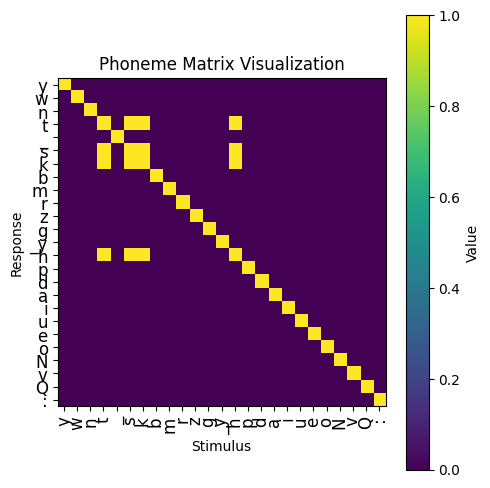

In [16]:
# サンプルの混合行列の作成。実際は実験や測定で取得する。
import itertools
import pandas as pd
import matplotlib.pyplot as plt

# 上で作成したローマ字変換から「音素」のリストを作成
single = filter(lambda k_v: len(k_v[1])==1,  kana_to_romaji.items())
single = list(map(lambda t: t[1], single))
print(single)
others = set([v[:-1] for k, v in kana_to_romaji.items()])
print(others)  # _は小さい母音、_yは幼音を示す
all_phonemes = list(filter(len, others)) + single
print(all_phonemes)

# サンプルとして、文字列 "ksth" から全組み合わせのデカルト積を作成する
combinations = list(itertools.product("ktsh", repeat=2))
# combinations += list(itertools.product("bd", repeat=2))
# combinations += list(itertools.product("mn", repeat=2))
# combinations += list(itertools.product("iu", repeat=2))
combinations = list(filter(lambda ij: ij[0]!=ij[1], combinations))

confusion_matrix = pd.DataFrame(0, index=all_phonemes, columns=all_phonemes)  # 初期値は0

# 対角成分を1に設定
N = len(all_phonemes)
for i in range(N):
  confusion_matrix.iat[i, i] = 1

for stim, res in combinations:
    # 一般的にsrc->tgtだが、
    # 論文に合わせてCMは列にstim(src)を持たせている
    confusion_matrix.loc[res, stim] += 1

# 行列をimshowを使用して可視化
plt.figure(figsize=(5, 5))
plt.imshow(confusion_matrix, cmap="viridis")  # 任意のカラーマップを指定できます
plt.colorbar(label="Value")
plt.xticks(ticks=range(N), labels=all_phonemes, rotation=90, fontsize=12)  # フォントサイズを設定
plt.yticks(ticks=range(N), labels=all_phonemes, fontsize=12)  # フォントサイズを設定
plt.xlabel("Stimulus")
plt.ylabel("Response")
plt.title("Phoneme Matrix Visualization")
plt.tight_layout()
plt.show()

In [17]:
from scipy.special import softmax

def cost_phoneme(cm, stim, resp):
    # こちらは編集コスト: 同じ知覚なら0
    # 一般的にsrc->tgtだが、
    # 論文に合わせてCMは列にstim(src)を持たせている
    return 1-cm.loc[resp, stim]

def compute_distance(cm, s1: list[str], s2: list[str]):
    len_s1 = len(s1)
    len_s2 = len(s2)

    # DPテーブルの初期化
    dp = [[0 for _ in range(len_s2 + 1)] for _ in range(len_s1 + 1)]
    for i in range(len_s1 + 1):
        for j in range(len_s2 + 1):
            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            else:
                cost = cost_phoneme(cm, s1[i-1], s2[j-1])
                insert = dp[i][j - 1] + 1
                delete = dp[i - 1][j] + 1
                replace = dp[i - 1][j - 1] + cost
                dp[i][j] = min(insert, delete, replace)

    return dp[len_s1][len_s2]

s1 = ['h', 'i', 'b', 'i', 'y', 'a']
s2 = ['s', 'i', 'b', 'u', 'y', 'a']

similarity = compute_distance(confusion_matrix, s1, s2)
print(similarity)

1


## 確率の考慮

In [22]:
import pandas as pd
import requests
from io import BytesIO

# ファイルIDを使用してダウンロードURLを作成
file_id = '1L9h-NYghhqqOSZ6IbcT1Ja3eqSX8xnfd'
download_url = f"https://drive.google.com/uc?id={file_id}"

# https://drive.google.com/file/d/1L9h-NYghhqqOSZ6IbcT1Ja3eqSX8xnfd/view

# ファイルをダウンロード
response = requests.get(download_url)
response.raise_for_status()
data = BytesIO(response.content)
word_freq = pd.read_pickle(data)

# 全単語の出現回数の合計を計算
total_words = sum(word_freq.values())
print(f"Word count size: {total_words}")

# 各単語の確率を計算
word_prob = {word: freq / total_words for word, freq in word_freq.items()}

for word in ["渋谷", "日比谷"]:
    print(f"{word}の頻度: {word_freq[word]}")

# 確認のため、いくつかの単語の確率を出力
for word in ["渋谷", "日比谷"]:
    print(f"Probability of '{word}': {word_prob.get(word, 0)}")

vocabulary_size = len(word_freq)
print(f"Vocabulary size: {vocabulary_size}")

Word count size: 4429337
渋谷の頻度: 78
日比谷の頻度: 11
Probability of '渋谷': 1.760985899244063e-05
Probability of '日比谷': 2.4834416527800887e-06
Vocabulary size: 206060


## 聞き間違いやすい語の特定

In [34]:
### 1. 単語の指定
# intended_word = '小説' # -> NA
i# ntended_word = 'ティッシュ' # -> NA (フィッシュ...は違いすぎるのか)
intended_word = "千駄ヶ谷"  # -> NA
intended_word = '拍手' # -> 握手 in 1st
intended_word = '市ヶ谷' # -> 握手 in 1st
intended_word = '灘' # -> 握手 in 1st
intended_word = '稲城' # -> 稲毛 in 2nd
intended_word = '日比谷'# -> 渋谷 in 2nd

import re
# パターンは、すべての音素を"|"で連結して生成
# all_phonemes の中の要素のみで最長マッチ
pattern = "|".join(sorted(all_phonemes, key=len, reverse=True))

def decompose_string(s, pattern):
    return re.findall(pattern, s)

intended_speech: list[str] = decompose_string(word_to_romaji(intended_word), pattern)
print(intended_speech)

### 2. 類似性の高い単語リストの取得
TOP_N = 1000
candidates = [(intended_word, 1)] + model.most_similar(intended_word, topn=TOP_N)
candidates[:20]

# データフレームの作成
df = pd.DataFrame(candidates, columns=["entity", "similarity"])

# 無駄な記号の削除: 青山_(東京都港区) -> 青山
df["entity"] = df["entity"].str.split("_").str[0]
df["entity"] = df["entity"].str.replace(r'[^\w]', '', regex=True)
df_grouped = df.groupby('entity')['similarity'].mean().reset_index()
df = df_grouped

df = df.sort_values(by='similarity', ascending=False).reset_index(drop=True)

### 3. 音素に変換し、距離を計算
# phonemeの追加
# ここ、やけに時間かかる(word_to_romajiが原因か)
df["phoneme"] = df["entity"].apply(word_to_romaji).apply(lambda s: decompose_string(s, pattern))

# audio_distanceの計算
# ここのintended_speechなどはcかvに分割したlist[str]じゃないとだめ。
df["audio_distance"] = df.apply(lambda row: compute_distance(cm=confusion_matrix, s1=intended_speech, s2=row["phoneme"]), axis=1)

### 4. 確率の追加
df["freq"] = df["entity"].apply(lambda x: word_freq.get(x, 0))
import numpy as np

### 5. 対数スケールにする
# freqの対数を取る
df['freq_log'] = np.log1p(df['freq'])
df['audio_distance_log'] = np.log1p(df['audio_distance'])
df['similarity_log'] = np.log1p(df['similarity'])

# min-max scalingを定義
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

# 各列に対してmin-max scalingを適用し、新しい列を作成
df['freq_log_s'] = min_max_scaling(df['freq_log'])
df['audio_distance_log_s'] = min_max_scaling(df['audio_distance_log'])
# 全て方向を揃える
df['audio_similarity_log_s'] = 1 - df['audio_distance_log_s']
df['similarity_log_s'] = min_max_scaling(df['similarity_log'])

import numpy as np
df.query("audio_similarity_log_s > 0.7").sort_values(by='freq_log_s', ascending=False)

['h', 'i', 'b', 'i', 'y', 'a']


,entity,similarity,phoneme,audio_distance,freq,freq_log,audio_distance_log,similarity_log,freq_log_s,audio_distance_log_s,audio_similarity_log_s,similarity_log_s
27,渋谷,0.663863,"[s, i, b, u, y, a]",1,78,4.369448,0.693147,0.509142,0.575966,0.21031,0.78969,0.395362
0,日比谷,0.901044,"[h, i, b, i, y, a]",0,11,2.484907,0.000000,0.642403,0.327552,0.00000,1.00000,1.000000
